# f-scLVM

In this notebook we illustrate how f-scLVM can be used to identify biological processes driving variability between cells. 

First, we load some modules and set some directories

In [3]:
import sys
sys.path.append('./../..')
import os
import scipy as SP
import cPickle as pickle
import core.utils as utils
import core.fscLVM as fscLVM

import h5py
%pylab inline

data_dir = '../../../data/'
out_base = './../results/'

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


f-scLVM expects a hdf file containing the normalised, log transformed gene expression data as well as a set of annotations.

In [4]:
dFile = 'Buettneretal.hdf5'
#name of annotation
anno = 'MSigDBdemo'

#number of hidden (unannotated variables)
nHidden = 3
#indices of known covariates
idx_known = []
#number of iterations
nIterations = 800

idxCol=[0,1]
#should the fast option be used (recommende). This only considers genes which are annotated to at least one process.
doFast=True

#specify out_dir
if doFast==False:      
    out_dir = os.path.join(out_base,  dFile.split('.')[0],anno)
else:
    out_dir = os.path.join(out_base,  dFile.split('.')[0],anno+'_fast')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

Next we need to load the relevant data from the hdf5 file.

In [5]:
#min. numer of genes per process
minGenes = 15
dataFile = h5py.File(os.path.join(data_dir, dFile), 'r')

terms = dataFile['terms'][:]#[50:]
pi = dataFile['Pi'][:].T#[:,50:]

Y = dataFile['Yhet'][:].T


#exclude small terms
terms = terms[SP.sum(pi>.5,0)>minGenes]
pi = pi[:,SP.sum(pi>.5,0)>minGenes]


#fast option?    
if doFast==True:
    idx_genes  = SP.logical_and(SP.sum(pi>.5,1)>0, Y.mean(0)>0.)#SP.any(pi>.5,1)
    Y = Y[:,idx_genes]
    pi = pi[idx_genes,:]    


#center data
Y-=SP.mean(Y,0)

#include hidden variables
terms = SP.hstack([SP.repeat('hidden',nHidden), terms])
pi = SP.hstack([SP.ones((Y.shape[1],nHidden))*.99,pi])


#include known covariates
init_factors = {}
if len(idx_known)>0:
    known_names = dataFile['known_names'][:][idx_known]
    if len(dataFile['Known'][:].shape)>1:
        known = dataFile['Known'][:].T[:,idx_known]
    else:
        known = dataFile['Known'][:][:,SP.newaxis]
    known -= known.mean(0)
    known /= known.std(0)
    terms = SP.hstack([ known_names,terms])
    pi = SP.hstack([SP.ones((Y.shape[1],len(idx_known)))*.5,pi])
    init_factors['Known'] = known             
else:
    known_names = '0'


terms0=terms.copy()
pi0=pi.copy()

Next, we initialise the model and iterate.


In [6]:
init_factors['iLatent'] = SP.where(terms=='hidden')[0]

#use pre-training to determine initial update order 
Ilabel = utils.getIlabel('preTrain',Y, terms, pi,init_factors) 

#re-order terms
print "Initial order", terms0[Ilabel]
terms = terms0[Ilabel]
pi = pi0[:,Ilabel]

#Set FNR
pi[pi<.1] =1e-3

#initialise model
init={'init_data':fscLVM.CGauss(Y),'Pi':pi,'init_factors':init_factors}
priors = {'Eps': {'priors':[1E-3,1E-3]}}
FA = fscLVM.CSparseFA(components=pi.shape[1], nIterations=nIterations, priors=priors,verbose=True)            
FA.init(**init) 

#iterate
FA.iterate(forceIterations=True)

Initial order ['hidden' 'hidden' 'hidden' 'G2M_CHECKPOINT' 'P53_PATHWAY'
 'UNFOLDED_PROTEIN_RESPONSE' 'EPITHELIAL_MESENCHYMAL_TRANSITION'
 'PROTEIN_SECRETION' 'UV_RESPONSE_UP' 'TNFA_SIGNALING_VIA_NFKB'
 'ADIPOGENESIS' 'IL2_STAT5_SIGNALING' 'MYOGENESIS' 'KRAS_SIGNALING_UP'
 'OXIDATIVE_PHOSPHORYLATION' 'MYC_TARGETS_V2' 'APICAL_SURFACE'
 'TGF_BETA_SIGNALING' 'XENOBIOTIC_METABOLISM' 'MTORC1_SIGNALING'
 'CHOLESTEROL_HOMEOSTASIS' 'PEROXISOME' 'MITOTIC_SPINDLE' 'MYC_TARGETS_V1'
 'ANDROGEN_RESPONSE' 'DNA_REPAIR' 'IL6_JAK_STAT3_SIGNALING'
 'PI3K_AKT_MTOR_SIGNALING' 'BILE_ACID_METABOLISM' 'SPERMATOGENESIS'
 'FATTY_ACID_METABOLISM' 'INTERFERON_ALPHA_RESPONSE' 'E2F_TARGETS'
 'APOPTOSIS' 'COMPLEMENT' 'ALLOGRAFT_REJECTION' 'COAGULATION'
 'HEME_METABOLISM' 'UV_RESPONSE_DN' 'GLYCOLYSIS' 'INFLAMMATORY_RESPONSE'
 'APICAL_JUNCTION' 'KRAS_SIGNALING_DN' 'HYPOXIA' 'ESTROGEN_RESPONSE_LATE'
 'INTERFERON_GAMMA_RESPONSE' 'ESTROGEN_RESPONSE_EARLY']
reconstruction error: 0.796483 
reconstruction error: 1.463068
r

0

We then post-process the result to exclude factors capturing outliers.

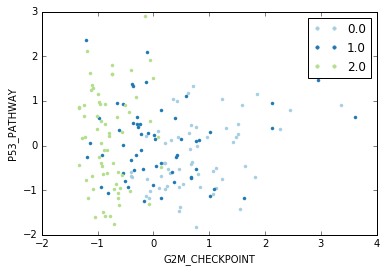

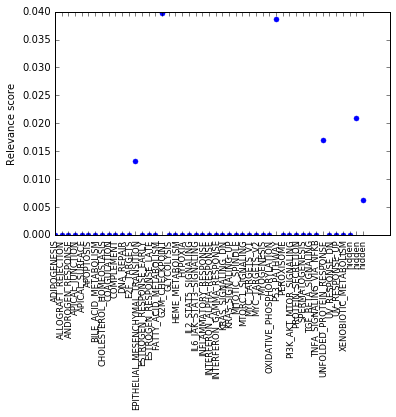

In [23]:
#scatter plot of two most important factors
utils.plotFactors(0,1,FA,lab = dataFile['Known'][:][0,:]+2*dataFile['Known'][:][1,:], terms=terms, isCont=False)
utils.plotTerms(FA, terms=terms)

In [20]:
#specify out_file
utils.saveFA(FA)